In [739]:
#1) Over 80 på rigtig model 
#2) Hvorfor er simple logistic model så god?
#2) Evaluation: f-score, mse, acc. for både liar og bigcorp. Både val og test
#3) Conclusion: visualizer alt i rapport
#3) what to do with nan values.

# Importing all packages

In [740]:
%matplotlib inline
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from cleantext import clean
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from collections import Counter
import subprocess
import zipfile
import io
import csv
import zipfile38 as zipfile
from dask import dataframe as dd
from sklearn.model_selection import train_test_split
import h5py
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.pyplot import bar
from matplotlib.pyplot import xticks
from matplotlib.pyplot import show
import itertools, sys
from collections import Counter


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simonmork/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Getting The news_cleaned csv and train, val, test

In [741]:
#Getting News_cleaned_2018_02_13
csv_textfilereader = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/news_cleaned_2018_02_13.csv', chunksize=1000000, iterator=True)
big_df = csv_textfilereader.get_chunk(10000)
first_article = big_df.iloc[0]
print(first_article)

Unnamed: 0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0
id                                                                                                                                                                                                                             

In [742]:
# Get Liar train datataset
print("Getting liar train csv...")
LiarTrain = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/liar_dataset/train.tsv', sep='\t')
# Save the third column as a list
LiarTrainArticles = LiarTrain.iloc[:, 2].values.tolist()
LiarTrainLables = LiarTrain.iloc[:, 1].values.tolist()
print(LiarTrainArticles[0])
print(LiarTrainLables[0])

Getting liar train csv...
When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
half-true


In [743]:
# Get Liar Val datataset
print("Getting liar val csv...")
LiarVal = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/liar_dataset/valid.tsv', sep='\t')
# Save the third column as a list
LiarValArticles = LiarVal.iloc[:, 2].values.tolist()
LiarValLables = LiarVal.iloc[:, 1].values.tolist()
print(LiarValArticles[0])
print(LiarValLables[0])


Getting liar val csv...
When Obama was sworn into office, he DID NOT use the Holy Bible, but instead the Kuran (Their equivalency to our Bible, but very different beliefs).
pants-fire


In [744]:
# Get Liar test datataset
print("Getting liar test csv...")
LiarTest = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/liar_dataset/test.tsv', sep='\t')




print(type(LiarTest))
# Save the third column as a list
LiarTestArticles = LiarTest.iloc[:, 2].values.tolist()
LiarTestLables = LiarTest.iloc[:, 1].values.tolist()
print(LiarTestArticles[0])
print(LiarTestLables[0])


Getting liar test csv...
<class 'pandas.core.frame.DataFrame'>
Wisconsin is on pace to double the number of layoffs this year.
false


# Defining all the functions we need

#### The cleantext function specifications

In [745]:
# Define settings for cleaning
def clean_text(text):
    """Calls the clean function from cleantext clean on a string"""
    t = clean(text,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,         # fully strip line breaks as opposed to only normalizing them NOT WORKING?
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="URL",
    replace_with_email="EMAIL",
    replace_with_phone_number="PHONE",
    replace_with_number="NUM",
    replace_with_digit="0",
    replace_with_currency_symbol="CUR",
    lang="en",                       # set to 'de' for German special handling
    )
    return t


pd.set_option("display.max_colwidth", 10000000)    
print("Done")    

Done


#### The clean articles funtionality. Not used atm.

In [746]:
def clean_article_texts(article_texts):
    # Download stopwords and initialize stemmer
    stop_words = set(stopwords.words('english'))
    snowball = SnowballStemmer(language='english')

    words_before = []
    unique_words_before = []
    words_clean = []
    unique_words_clean = []
    words = []
    unique_words = []



    for article in article_texts:
        #Get number of words and unique words before clean
        words_before.extend(article)
        unique_words_before_set =  set(word for word_list in article for word in word_list)
        unique_words_before.extend(unique_words_before_set) 
        

        # Clean the text
        cleaned = clean_text(article)      
        
        #Get number of words and unique words after clean  
        words_clean.extend(cleaned.split())
        unique_words_clean_set = set(word for word_list in article for word in word_list)
        unique_words_clean.extend(unique_words_clean_set) 
        

        # Tokenize the text
        words = nltk.word_tokenize(cleaned)

        # Remove stopwords and stem the words
        filtered_words = [snowball.stem(word.lower()) for word in words if word.lower() not in stop_words]        
        words.append(filtered_words)
        unique_words_set = [word for words in filtered_words for word in words]
        unique_words.append(unique_words_set)
        

    return words_before, unique_words_before, words_clean, unique_words_clean, filtered_words, unique_words



#### The clean function for a df column

In [747]:
    # Clean dataframe function
def clean_df(df, label):
        column_names = list(df.columns)
        #print(column_names)

        #for index, row in df.iterrows():
            #print(df.at[index,'content']) 



        print("Getting num words...")
        # unique words and num before clean
        words = df[label].str.split()
        #print(words)
        unique_words_before = set(word for word_list in words for word in word_list)
        #print(type(unique_words_before))
        #unique_words_before = set(words)
        #print(unique_words_before)
        #print(unique_words_before)
        #word_counts = Counter(unique_words_before)
        #unique_words_before_sort = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        #unique_words_before = [word[0] for word in unique_words_before_sort]
        #print(unique_words_before_sort)
        # Count the number of unique words
        num_unique_words_before = len(unique_words_before)
        #print(num_unique_words_before) 
        print("Number unique words before cleaning: ", num_unique_words_before)
        #print(unique_words_before) 
        
        #Number of words before clean
        word_list_before = [word for row in df[label] for word in row]
        # Count the number of words in the list
        total_word_count_before = len(word_list_before)
        print("Total word count before clean: ", total_word_count_before, "\n")


        print("Cleaning...")
        for index, row in df.iterrows():
            #print("Before: \n\n", df.at[index,'content'])
            cleaned = clean_text(df.at[index,label])
            df.at[index,label] = cleaned
            #print("\n\ncleaned: \n\n", cleaned)
            #print(cleaned)
            
            
        # unique words and num after clean
        words_clean = df[label].str.split()
        unique_words_clean = set(word for word_list in words_clean for word in word_list)
        #unique_words_clean = words_clean
        #word_counts_clean = Counter(unique_words_clean)
        #unique_words_clean_sort = sorted(word_counts_clean.items(), key=lambda x: x[1], reverse=True)
        #unique_words_clean = [word[0] for word in unique_words_clean_sort]
        num_unique_words_clean = len(unique_words_clean)
        print("Number of unique words after cleaning", num_unique_words_clean) 
        print("How many percent unique words were removed ", 1-num_unique_words_clean/num_unique_words_before) 
        #print(unique_words_clean) 

        #Number of words after clean
        word_list_clean = [word for row in df[label] for word in row]
        # Count the number of words in the list
        total_word_count_clean = len(word_list_clean)
        print("Total word count after clean: ", total_word_count_clean)
        print("Percent of words removed: ", 1-total_word_count_clean/total_word_count_before, "\n")


        print("Tokenizing and removing stopwords...")
        #stopped = 0
        stop_words = set(stopwords.words('english'))
        for index, row in df.iterrows():    
            #print("\n\nbefore: \n\n", df.at[index,'content'])
            #print(row['content'])
            df.at[index,label] = nltk.word_tokenize(row[label])
            
            filtered_sentence = []
            for w in df.at[index,label]:
                if w not in stop_words:
                    filtered_sentence.append(w)
                #else:
                    #stopped += 1
            
            df.at[index,label] = filtered_sentence
            #print("\n\nafter: \n\n", filtered_sentence)

        #print("Stopped: ", stopped)
        # Unique words and num after stop
        words = set(word for content in df[label] for word in content)
        #print(words)
        # get the set of unique words
        unique_words_stop = set(words)
        #word_counts_stop = Counter(unique_words_stop)
        #unique_words_stop_sort = sorted(word_counts_stop.items(), key=lambda x: x[1], reverse=True)
        # get the number of unique words
        #unique_words_stop = [word[0] for word in unique_words_stop_sort]
        num_unique_words_stop = len(unique_words_stop)
        print("Number of unique words after removing stopwords: ", num_unique_words_stop)
        print("How many percent were removed: ", 1-num_unique_words_stop/num_unique_words_clean)
        #print(unique_words_stop)     

        #Number of words after stopwords removed
        word_list_stop = [word for row in df[label] for word in row]
        # Count the number of words in the list
        total_word_count_stop = len(word_list_stop)
        print("Total word count after stopwords removed: ", total_word_count_stop)
        print("Percent of words removed: ", 1-total_word_count_stop/total_word_count_clean,  "\n")

        print("Stemming")
        snowball = SnowballStemmer(language='english')
        for index, row in df.iterrows():   
            stemmed = []
            for word in df.at[index,label]:
                stemmed.append(snowball.stem(word))
            df.at[index,label] = stemmed
            #print(stemmed)


        # concatenate all the lists into a single list of words
        words = [word for content in df[label] for word in content]
        # get the set of unique words
        unique_words_stem = set(words)
        # get the number of unique words
        #word_counts_stem = Counter(unique_words_stem)
        #unique_words_stem_sort = sorted(word_counts_stem.items(), key=lambda x: x[1], reverse=True)
        #unique_words_stem = [word[0] for word in unique_words_stem_sort]
        num_unique_words_stem = len(unique_words_stem)
        print("Number of unique words after stemming: ", num_unique_words_stem)
        print("How many percent were removed: ", 1-num_unique_words_stem/num_unique_words_stop)
        #print(unique_words_stem) 

        #Number of words after stemming
        word_list_stem = [word for row in df[label] for word in row]
        # Count the number of words in the list
        total_word_count_stem = len(word_list_stem)
        print("Total word count after stemming: ", total_word_count_stem)
        print("Percent of words removed: ", 1-total_word_count_stem/total_word_count_stop, "\n")


        print("Done...")
        return df, unique_words_before, unique_words_clean, unique_words_stop, unique_words_stem, total_word_count_before, total_word_count_clean, total_word_count_stop, total_word_count_stem
        


#### Function to vectorize a set and unique words to get same dimensions
##### X_vectoriser is a function that takes in a list of text data as input, concatenates the words in each string, and transforms the resulting text data into a sparse matrix representation using the CountVectorizer from scikit-learn. The resulting matrix can be used as input to machine learning algorithms.

In [748]:
def X_vectoriser(vectee, unique_words):
    vectee = [' '.join(words) for words in vectee]
    vectorizer = CountVectorizer(vocabulary=unique_words)
    vectee = vectorizer.fit_transform(vectee)
    return vectee

#### Function to make the labels binary.
##### make_bin is a function that takes in a list of categorical data and converts it into a list of binary labels. The function iterates through the input list and assigns a binary label of 0 to each non-'fake' element and a label of 1 to each 'fake' element. The resulting binary labels are returned as a list, which can be used as target values for machine learning algorithms.

In [749]:
def make_bin(to_bin):
    to_bin = np.asarray(to_bin)
    reliable = 0
    fake = 0
    bin_list = []
    for i in range(len(to_bin)):
        if to_bin[i] == "nan":
            print("nan")
        if to_bin[i] == "Na":
            print("Na")
        if to_bin[i] != 'fake' and to_bin[i] != 'satire' and to_bin[i] != 'conspiracy' and to_bin[i] != 'junksci' and to_bin[i] != 'hate' and to_bin[i] != 'clickbait' and to_bin[i] != 'unreliable' and to_bin[i] != 'rumor' and to_bin[i] != 'false' and to_bin[i] != 'pants-fire' and to_bin[i]!='nan':
            bin_list.append(0)
            reliable = reliable +1
        else:
            bin_list.append(1)
            fake = fake+1
        #print(to_bin[i])
    return bin_list, fake, reliable

#### How to save data to csv file

In [750]:
""" # Save original data to CSV
first_chunk.to_csv('original_data.csv', index=False)

# Clean the data
cleaned_df = clean_df(first_chunk)

# Save cleaned data to CSV
cleaned_df.to_csv('cleaned_data.csv', index=False) """

" # Save original data to CSV\nfirst_chunk.to_csv('original_data.csv', index=False)\n\n# Clean the data\ncleaned_df = clean_df(first_chunk)\n\n# Save cleaned data to CSV\ncleaned_df.to_csv('cleaned_data.csv', index=False) "

## The big Dataset

#### Cleaning the big dataset

In [751]:
big_df, unique_words_before_big, unique_words_clean_big, unique_words_stop_big, unique_words_stem_big, total_word_count_before_big, total_word_count_clean_big, total_word_count_stop_big, total_word_count_stem_big = clean_df(big_df, 'content')


Getting num words...
Number unique words before cleaning:  302318
Total word count before clean:  43111188 

Cleaning...
Number of unique words after cleaning 114682
How many percent unique words were removed  0.6206577180320061
Total word count after clean:  41300388
Percent of words removed:  0.04200301787090632 

Tokenizing and removing stopwords...
Number of unique words after removing stopwords:  114281
How many percent were removed:  0.003496625451247848
Total word count after stopwords removed:  4012409
Percent of words removed:  0.9028481524192945 

Stemming
Number of unique words after stemming:  84160
How many percent were removed:  0.2635696222469177
Total word count after stemming:  4012409
Percent of words removed:  0.0 

Done...


#### Getting some stats on the big dataset

In [752]:
#Part 1 - Task 2
print("Counting number of urls, dates and num, and fake news and trump")
url = 0
num = 0
trump=0
fakenews = 0
notfake = 0

for index, row in big_df.iterrows():
    for word in big_df.at[index,'content']:
        #print(word)
        if word == 'url':
            url = url+1
        if word == 'num':
            num = num+1
        if word == 'trump':
            trump = trump+1
    if big_df.at[index,'type'] == 'fake':
        fakenews = fakenews+1
    else:
        notfake = notfake+1
print("Num urls: ", url)
print("Num num: ", num)
print("Num trump: ", trump)
print("Num fake: ", fakenews)
print("Num notfake: ", notfake)

Counting number of urls, dates and num, and fake news and trump
Num urls:  6148
Num num:  96554
Num trump:  15289
Num fake:  3663
Num notfake:  6337


Visualization of the key properties of the dataset

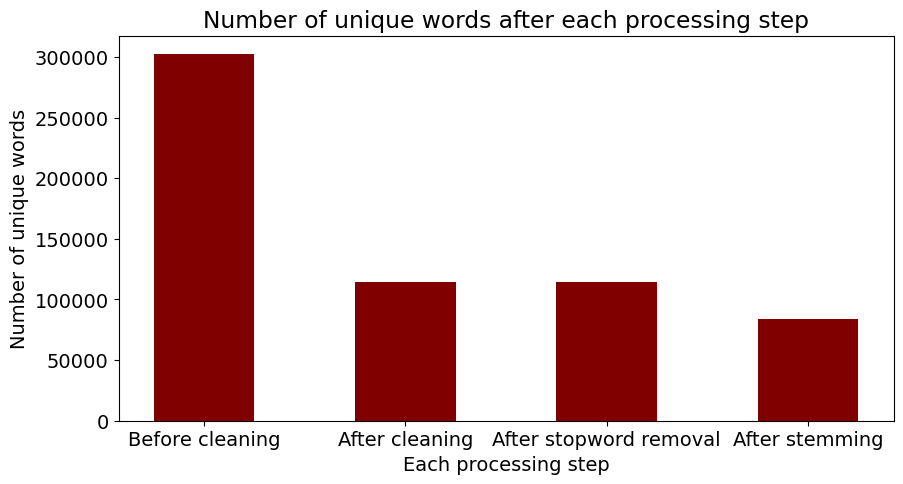

In [753]:
# Plotting the bar chart 
data = {'Before cleaning': len(unique_words_before_big), 'After cleaning': len(unique_words_clean_big), 'After stopword removal': len(unique_words_stop_big), 'After stemming': len(unique_words_stem_big)}
dataset = list(data.keys())
values = list(data.values())
bar(dataset, values, color = 'maroon', width = 0.5)
plt.xlabel('Each processing step')
plt.ylabel('Number of unique words')
plt.title('Number of unique words after each processing step')
plt.rcParams["figure.figsize"] = [10.0, 5.0]
font = {'size' : 14}
plt.rc('font', **font)
plt.show()

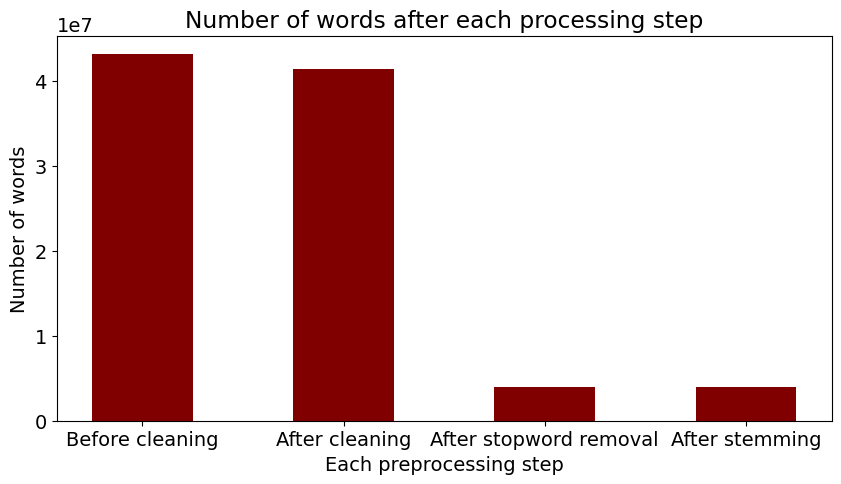

In [754]:
# Plotting the bar chart 
data = {'Before cleaning': total_word_count_before_big, 'After cleaning': total_word_count_clean_big, 'After stopword removal': total_word_count_stop_big, 'After stemming': total_word_count_stem_big}
dataset = list(data.keys())
values = list(data.values())
bar(dataset, values, color = 'maroon', width = 0.5)
plt.xlabel('Each preprocessing step')
plt.ylabel('Number of words')
plt.title('Number of words after each processing step')
plt.rcParams["figure.figsize"] = [10.0, 5.0]
font = {'size' : 14}
plt.rc('font', **font)
plt.show()

#### Splitting the data
##### This code splits a DataFrame df into training, validation, and testing sets, with a 80:10:10 ratio. The X variable contains the content of the articles, while the y variable contains the type of the articles (reliable/fake).

In [755]:
X, y = big_df.content, big_df['type']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)


#### Transform text big csv data into a sparse matrix representation
##### To make predictions later

In [756]:
X_train_vec = X_vectoriser(X_train, unique_words_stem_big)
X_val_vec = X_vectoriser(X_val, unique_words_stem_big)
X_test_vec = X_vectoriser(X_test, unique_words_stem_big)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


### Handling the labels for big data

In [757]:
y_train_bin, LabelFa, LabelRe  = make_bin(y_train)
y_val_bin, no1, no2 = make_bin(y_val)
y_test_bin, no3, no4 = make_bin(y_test)


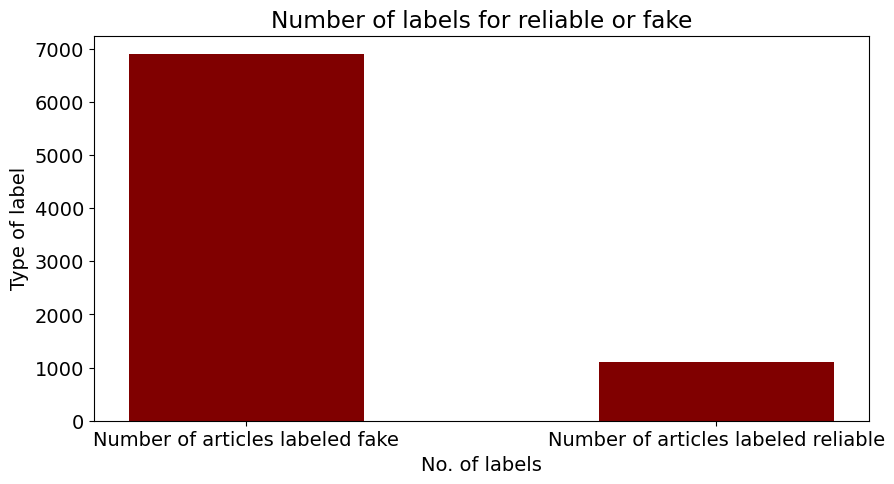

In [758]:
# Bar chart showing number of fake labels and number of reliable
data = {'Number of articles labeled fake': LabelFa, 'Number of articles labeled reliable': LabelRe }
labels = list(data.keys())
values = list(data.values())
bar(labels, values, color = 'maroon', width= 0.5)
plt.xlabel('No. of labels')
plt.ylabel('Type of label')
plt.title('Number of labels for reliable or fake')
plt.rcParams["figure.figsize"] = [10.0, 5.0]
font = {'size' : 14}
plt.rc('font', **font)
plt.show()

## The Liar dataset

#### Cleaning the Liar dataset

In [759]:
#X_val_liar, k1, k2,k3, UWC = clean_df(LiarVal, 2)
LiarVal.columns = ['col1', 'col2', 'content', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14']
#LiarVal = LiarVal.rename(columns={2: 'content'})
#print("Headers: ", LiarVal.columns.values)
#print(LiarVal)
Liar_df, unique_words_before_liar, unique_words_clean_liar, unique_words_stop_liar, unique_words_stem_liar, total_word_count_liar, total_word_count_liar, total_word_count_liar, total_word_count_liar = clean_df(LiarVal, 'content')

Getting num words...
Number unique words before cleaning:  6096
Total word count before clean:  136968 

Cleaning...
Number of unique words after cleaning 4275
How many percent unique words were removed  0.2987204724409449
Total word count after clean:  133657
Percent of words removed:  0.024173529583552344 

Tokenizing and removing stopwords...
Number of unique words after removing stopwords:  4155
How many percent were removed:  0.028070175438596467
Total word count after stopwords removed:  14337
Percent of words removed:  0.8927328909073224 

Stemming
Number of unique words after stemming:  3158
How many percent were removed:  0.23995186522262335
Total word count after stemming:  14337
Percent of words removed:  0.0 

Done...


#### Vectorizing the liar datset

In [760]:
X_val_liar = X_vectoriser(Liar_df.content, unique_words_stem_big)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


#### Making the labels for liar dataset binary

In [761]:
y_val_liar, no5, no6 = make_bin(LiarValLables)

## Models:

### A simple logistic model:

#### Training on FakeNewsCorpus and predicting on the FakeNewsCorpus val dataset

In [762]:
simple_log_model = LogisticRegression(max_iter=100000)
simple_log_model.fit(X_train_vec, y_train_bin)
y_pred = simple_log_model.predict(X_val_vec)

acc_simple_log = accuracy_score(y_val_bin, y_pred)
print("Accuracy of simple logistic regression: ", acc_simple_log)


Accuracy of simple logistic regression:  0.915


#### Training on FakeNewsCorpus and Predicting on the liar validation set: 

In [763]:
simple_log_model_liar = LogisticRegression(max_iter=100000)
simple_log_model_liar.fit(X_train_vec, y_train_bin)
y_pred = simple_log_model_liar.predict(X_val_liar)

acc_simple_log = accuracy_score(y_val_liar, y_pred)
print(accuracy_score(y_val_liar, y_pred))

0.2961808261886204


#### Gaussion model: (kan ikke køre med lige så meget data som den logistiske)


In [764]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# create a RandomUnderSampler instance
rus = RandomUnderSampler(random_state=0)

# fit and transform the training data using RandomUnderSampler
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_vec.toarray(), y_train_bin)

# train the model on the resampled data
simple_nb_model = GaussianNB()
simple_nb_model.fit(X_train_resampled, y_train_resampled)

# make predictions on the validation data
y_pred_gauss = simple_nb_model.predict(X_val_vec.toarray())

# evaluate the accuracy of the model's predictions
acc_gauss = accuracy_score(y_val_bin, y_pred_gauss)
print(accuracy_score(y_val_bin, y_pred_gauss))


0.707


#### predicting on the liar dataset

In [765]:
y_pred_gauss_liar = simple_nb_model.predict(X_val_liar.toarray())

# evaluate the accuracy of the model's predictions on liar
acc_gauss_liar = accuracy_score(y_val_liar, y_pred_gauss_liar)
print(acc_gauss_liar)

0.6438035853468433


### Simlpe logistic model with meta (author and domain)

#### Make the data include the authors and domains

In [766]:

for index, row in big_df.iterrows():
    #print("df.at[index,'authors']", df.at[index,'authors'])
    if big_df.at[index,'authors'] != "nan":
        split_str = str(big_df.at[index,'authors']).split(", ")
        for word in split_str:
            author_str = "authors: " + word.lower()
            big_df.at[index,'content'].append(author_str)
    if  big_df.at[index,'domain'] != "nan":
        domain_str = "domain: " + str(big_df.at[index,'domain'])
        big_df.at[index,'content'].append(domain_str.lower())
    

#print(df['content'][1])

X_meta, y_meta = big_df.content, big_df['type']


X_train_meta, X_temp_meta, y_train_meta, y_temp_meta = train_test_split(X_meta, y_meta, test_size = 0.2, random_state = 0)
X_test_meta, X_val_meta, y_test_meta, y_val_meta = train_test_split(X_temp_meta, y_temp_meta, test_size = 0.5, random_state = 0)


X_train_vec_meta = X_vectoriser(X_train_meta, unique_words_stem_big)
X_val_vec_meta = X_vectoriser(X_val_meta,unique_words_stem_big)
X_test_vec_meta = X_vectoriser(X_test_meta, unique_words_stem_big)

y_train_bin_meta, LabelFa, LabelRe  = make_bin(y_train_meta)
y_val_bin_meta, LabelFa, LabelRe  = make_bin(y_val_meta)
y_test_bin_meta, LabelFa, LabelRe = make_bin(y_test_meta)



/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


#### Predict with simple model and meta

In [767]:
simple_log_model_meta = LogisticRegression(max_iter=100000)
simple_log_model_meta.fit(X_train_vec_meta, y_train_bin_meta)
y_pred_meta = simple_log_model_meta.predict(X_val_vec_meta)

acc_simple_log_meta = accuracy_score(y_val_bin_meta, y_pred_meta)
print(accuracy_score(y_val_bin_meta, y_pred_meta))

0.937


#### Comparing the simple model without metadata and the simple model with metadata:

In [768]:
#Comparison of acc bewteen simple log models

acc_diff_logs = abs(acc_simple_log_meta - acc_simple_log)
print(acc_diff_logs)

0.6408191738113796


#### making and predicting for the Gaussian model

In [769]:
# create a RandomUnderSampler instance
rus_meta = RandomUnderSampler(random_state=0)

# fit and transform the training data using RandomUnderSampler
X_train_resampled_meta, y_train_resampled_meta = rus_meta.fit_resample(X_train_vec_meta.toarray(), y_train_bin_meta)

# train the model on the resampled data
simple_nb_model_meta = GaussianNB()
simple_nb_model_meta.fit(X_train_resampled_meta, y_train_resampled_meta)

# make predictions on the validation data
y_pred2_meta = simple_nb_model_meta.predict(X_val_vec_meta.toarray())

# evaluate the accuracy of the model's predictions
acc_gaus_meta = accuracy_score(y_val_bin_meta, y_pred2_meta)
print(accuracy_score(y_val_bin_meta, y_pred2_meta))

0.748


#### Comparing the gaussian with and without metadata

In [770]:
#Comparison of acc between simple gauss models
#Frst run randomstate=42: 0.038000000000000034
#Second run, randomstate=0: 0.04

acc_diff_gauss = abs(acc_gauss - acc_gaus_meta)
print(acc_diff_gauss)

0.041000000000000036


## DEN KOMPLICEREDE MODEL:

Accuracy for C=0.1: 0.907
Best C: 0.1
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       156
           1       0.95      0.94      0.94       844

    accuracy                           0.91      1000
   macro avg       0.82      0.84      0.83      1000
weighted avg       0.91      0.91      0.91      1000



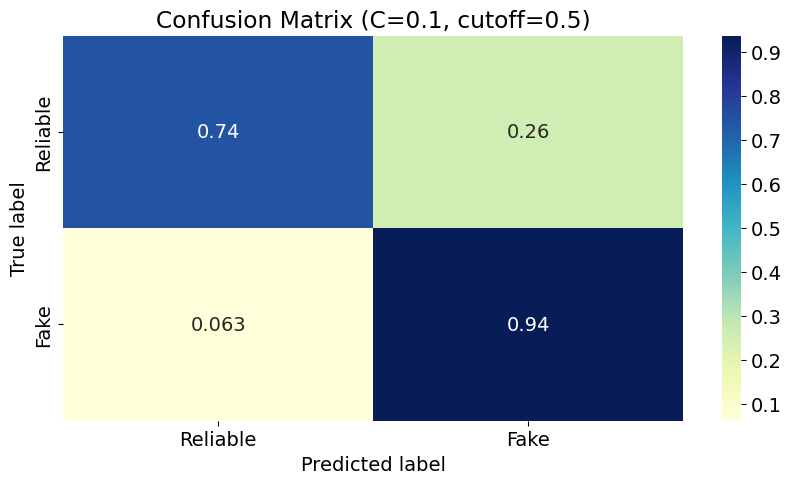

In [771]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

Cs = [0.1]
best_accuracy = 0
best_c = 0
best_y_pred = None

for c in Cs:
    simple_log_model = LogisticRegression(max_iter=100000, C=c, class_weight='balanced')
    simple_log_model.fit(X_train_vec, y_train_bin)
    y_pred = simple_log_model.predict(X_val_vec)
    accuracy = accuracy_score(y_val_bin, y_pred)
    print(f"Accuracy for C={c}: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_c = c
        best_y_pred = y_pred

print("Best C:", best_c)

# generate class probabilities and select cutoff
probas = simple_log_model.predict_proba(X_val_vec)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f'Confusion Matrix (C={best_c}, cutoff={cutoff})')
plt.show()


<AxesSubplot:>

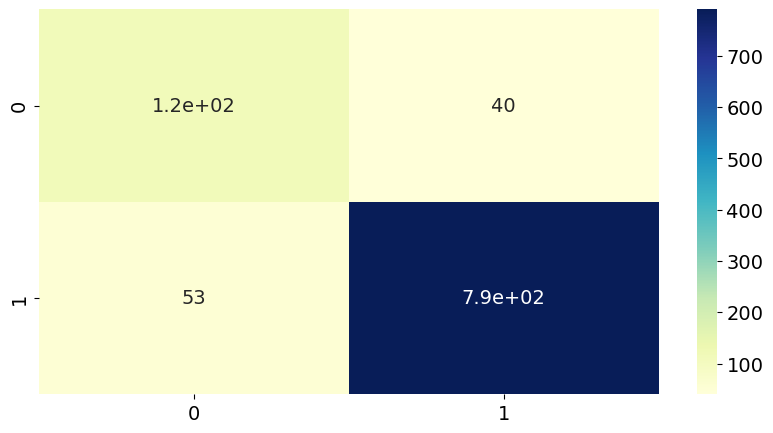

In [772]:
# calculate and plot confusion matrix with absolute values
conf_mat1 = confusion_matrix(y_val_bin, best_y_pred)
sns.heatmap(conf_mat1, annot=True, cmap="YlGnBu")